# Income Classification

Original Dataset: https://archive.ics.uci.edu/ml/datasets/adult

# TODO
Welche Kategorien haben aussagekräftige Verteilungen?
Boxplots nach Zielgröße und Kategorien

### Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from matplotlib.patches import Patch
import category_encoders as ce

## Preparation

### Load data

In [2]:
train_df = pd.read_csv('adult.data', delimiter=',', skipinitialspace=True, na_values=['?'])
test_df = pd.read_csv('adult.test', delimiter=',', skipinitialspace=True, na_values=['?'])

train_df_size = train_df.shape[0]
test_df_size = test_df.shape[0]
df_size = train_df_size + test_df_size

print(f'Train Dataset Size: {train_df_size} ({(train_df_size/df_size):.2%})')
print(f'Test Dataset Size: {test_df_size} ({(test_df_size/df_size):.2%})')

Train Dataset Size: 32561 (66.67%)
Test Dataset Size: 16281 (33.33%)


### Pre Processing

First we need to label the data with ones for income >50k and zeros for income <=50k.

In [3]:
train_df['income'] = train_df['income'].apply(lambda x: 1 if x == '>50K' else 0)
test_df['income'] = test_df['income'].apply(lambda x: 1 if x == '>50K' else 0)

**education** is encoded in **education-num** with numbe from 1 to 16. We can also drop this variable, because the information is useless.

In [4]:
train_df = train_df.drop('education-num',axis= 1)
test_df = test_df.drop("education-num", axis = 1)

### Dataset Info

The dataset contains 9 character variables and 6 numerical variables.
**income** is the target variable.

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   marital-status  32561 non-null  object
 5   occupation      30718 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  31978 non-null  object
 13  income          32561 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


### Dataset statistics

### Check missing values and fill it with most recent values

In [6]:
train_df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [7]:
train_df['workclass'].fillna(train_df['workclass'].mode()[0], inplace=True)
train_df['occupation'].fillna(train_df['occupation'].mode()[0], inplace=True)
train_df['native-country'].fillna(train_df['native-country'].mode()[0], inplace=True)   

test_df['workclass'].fillna(train_df['workclass'].mode()[0], inplace=True)
test_df['occupation'].fillna(train_df['occupation'].mode()[0], inplace=True)
test_df['native-country'].fillna(train_df['native-country'].mode()[0], inplace=True)   

In [8]:
train_df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

## Numeric

In [9]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
capital-gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital-loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours-per-week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0
income,32561.0,0.240810,0.427581,0.0,0.0,0.0,0.0,1.0


## Variables

In [10]:
categorical = [var for var in train_df.columns if train_df[var].dtype==object]
numeric = [var for var in train_df.columns if train_df[var].dtype!=object]
numeric.remove("income")

print('There are {} categorical variables:\n'.format(len(categorical)))

for var in categorical:

    print(f'{var} contains {len(train_df[var].unique())} labels')

print('\nThere are {} numeric variables:\n\n{}'.format(len(numeric), numeric))

There are 8 categorical variables:

workclass contains 8 labels
education contains 16 labels
marital-status contains 7 labels
occupation contains 14 labels
relationship contains 6 labels
race contains 5 labels
sex contains 2 labels
native-country contains 41 labels

There are 5 numeric variables:

['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']


# Charts

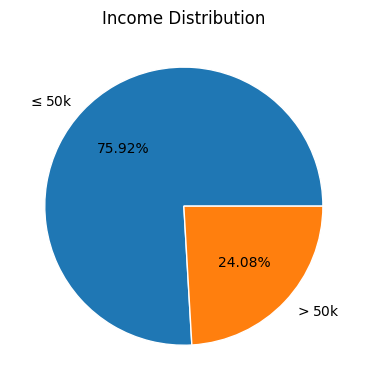

In [11]:
plt.figure(figsize=(4,4))
train_df['income'].value_counts().plot.pie(labels=[r'$\leq50$k', r'$>50$k'], autopct='%1.2f%%', wedgeprops = {"linewidth": 1, "edgecolor": "white"})
plt.title('Income Distribution')
plt.tight_layout()
plt.ylabel('')
plt.show()

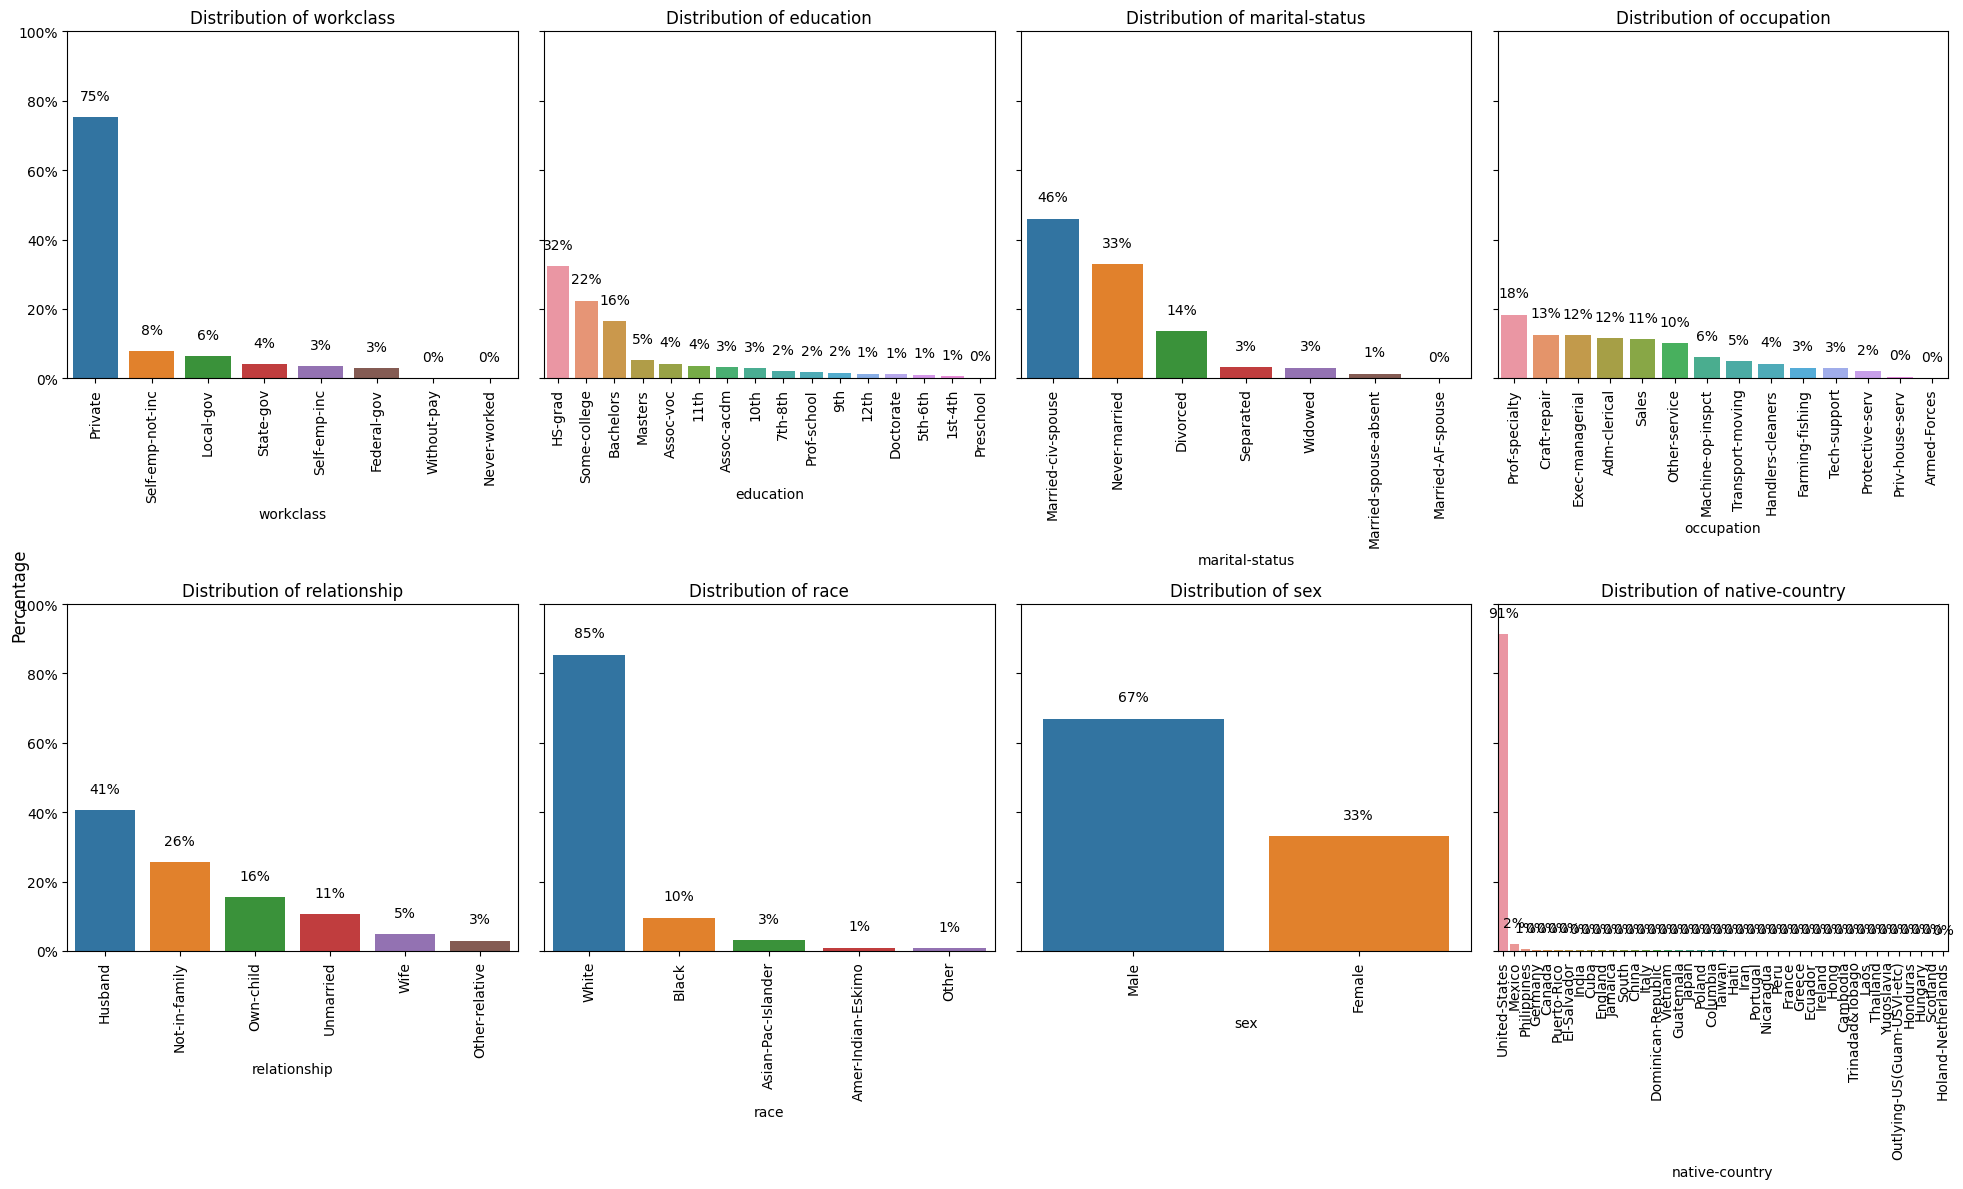

In [12]:
rows=2
cols=4

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 6*rows), sharey=True)
fig.supylabel('Percentage')

for i, variable in enumerate(categorical):
    row = i // cols
    col = i % cols
    ax = axes[row][col]
    pct_counts = train_df[variable].value_counts(normalize=True)
    sns.barplot(x=pct_counts.index, y=pct_counts.values, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    yticks = mtick.PercentFormatter(1)
    ax.yaxis.set_major_formatter(yticks)
    ax.set_ylim([0, 1])
    ax.set_title('Distribution of {}'.format(variable))

    for j, p in enumerate(ax.patches):
        ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.05, '{:.0%}'.format(pct_counts.values[j]), ha='center')

plt.tight_layout()
plt.show()

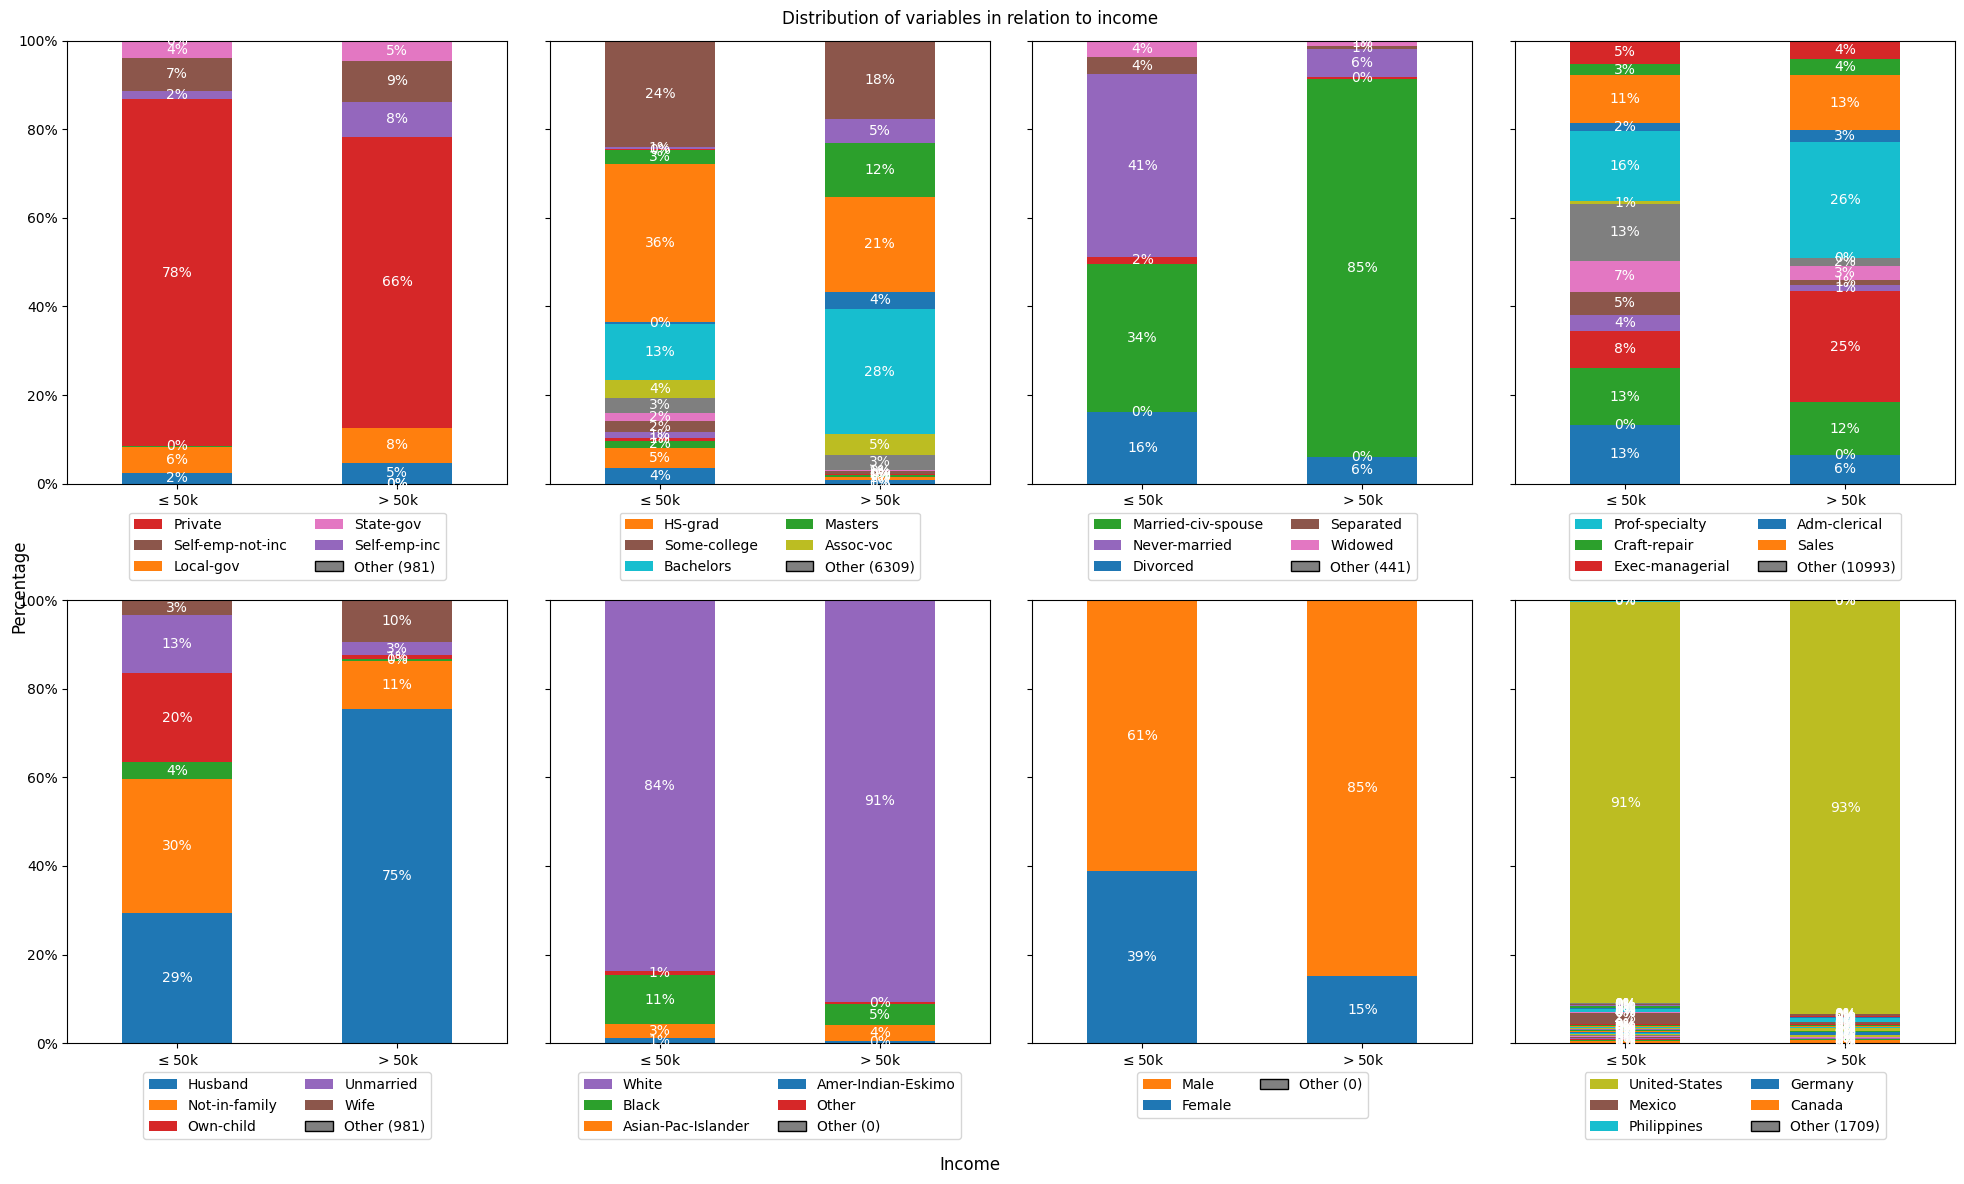

In [13]:
rows=2
cols=4

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 6*rows), sharey=True)
fig.suptitle('Distribution of variables in relation to income')
fig.supxlabel('Income')
fig.supylabel('Percentage')

for i, variable in enumerate(categorical):
    row = i // cols
    col = i % cols
    ax = axes[row][col]
    
    ct = pd.crosstab(train_df['income'], train_df[variable])
    ct_pct = ct.apply(lambda r: r/r.sum(), axis=1)

    ct_pct.plot(kind='bar', stacked=True, ax=ax)
    
    ax.set_xticklabels([r'$\leq50$k', r'$>50$k'], rotation=0)
    yticks = mtick.PercentFormatter(1)
    ax.yaxis.set_major_formatter(yticks)
    ax.set_ylim([0, 1])
    ax.set_xlabel('')

    handles, labels = ax.get_legend_handles_labels()
    sorted_labels = sorted(labels, key=lambda x: -ct[x].sum())
    top_labels = sorted_labels[:5]
    remaining_labels = sorted_labels[5:]
    top_handles = [handles[labels.index(l)] for l in top_labels]
    remaining_sum = sum([ct[x].sum() for x in remaining_labels])
    top_labels.append(f'Other ({remaining_sum})')
    top_handles.append(Patch(facecolor='gray', edgecolor='black'))
    ax.legend(top_handles, top_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)


    for i in ax.containers:
        ax.bar_label(i, label_type='center', color="white", fontsize=10, fmt='{:.0%}')

plt.tight_layout()
plt.show()

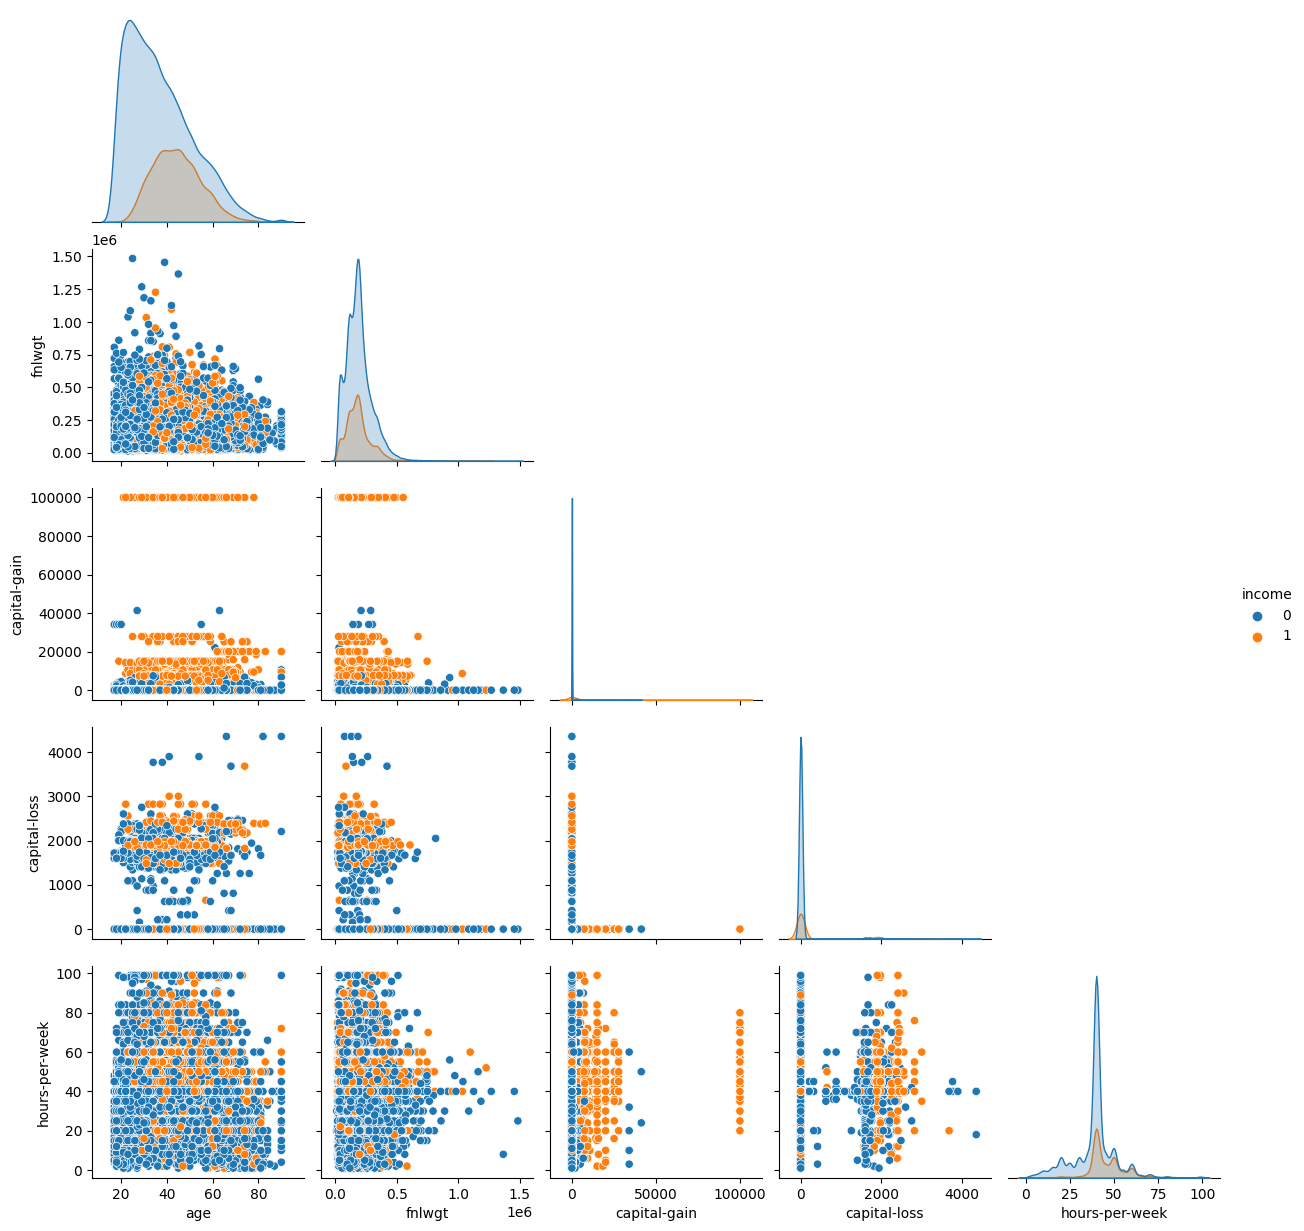

In [14]:
sns.pairplot(train_df, hue='income', corner=True)
plt.show()

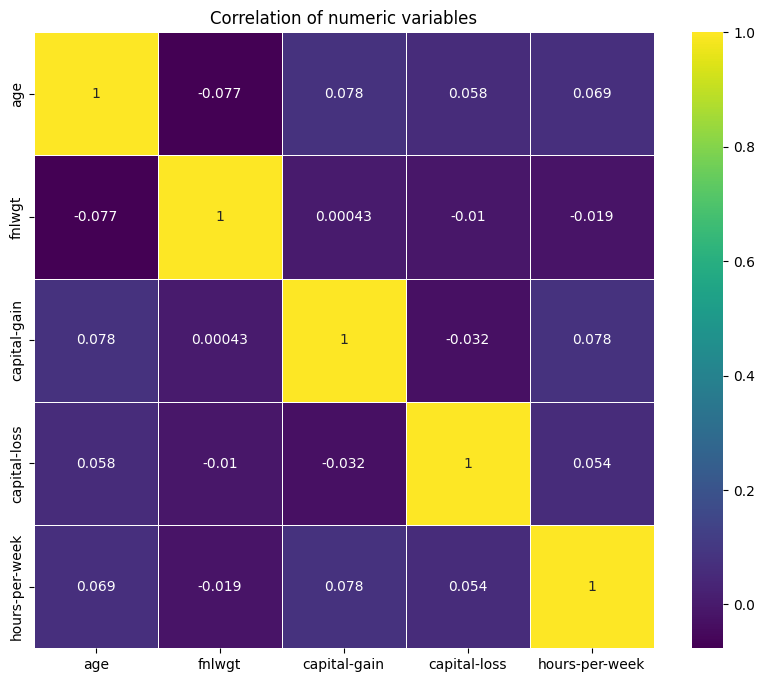

In [15]:
plt.figure(figsize=(10,8),dpi=100)
sns.heatmap(train_df[numeric].corr(),cmap="viridis",annot=True,linewidth=0.5)
plt.title("Correlation of numeric variables")
plt.show()

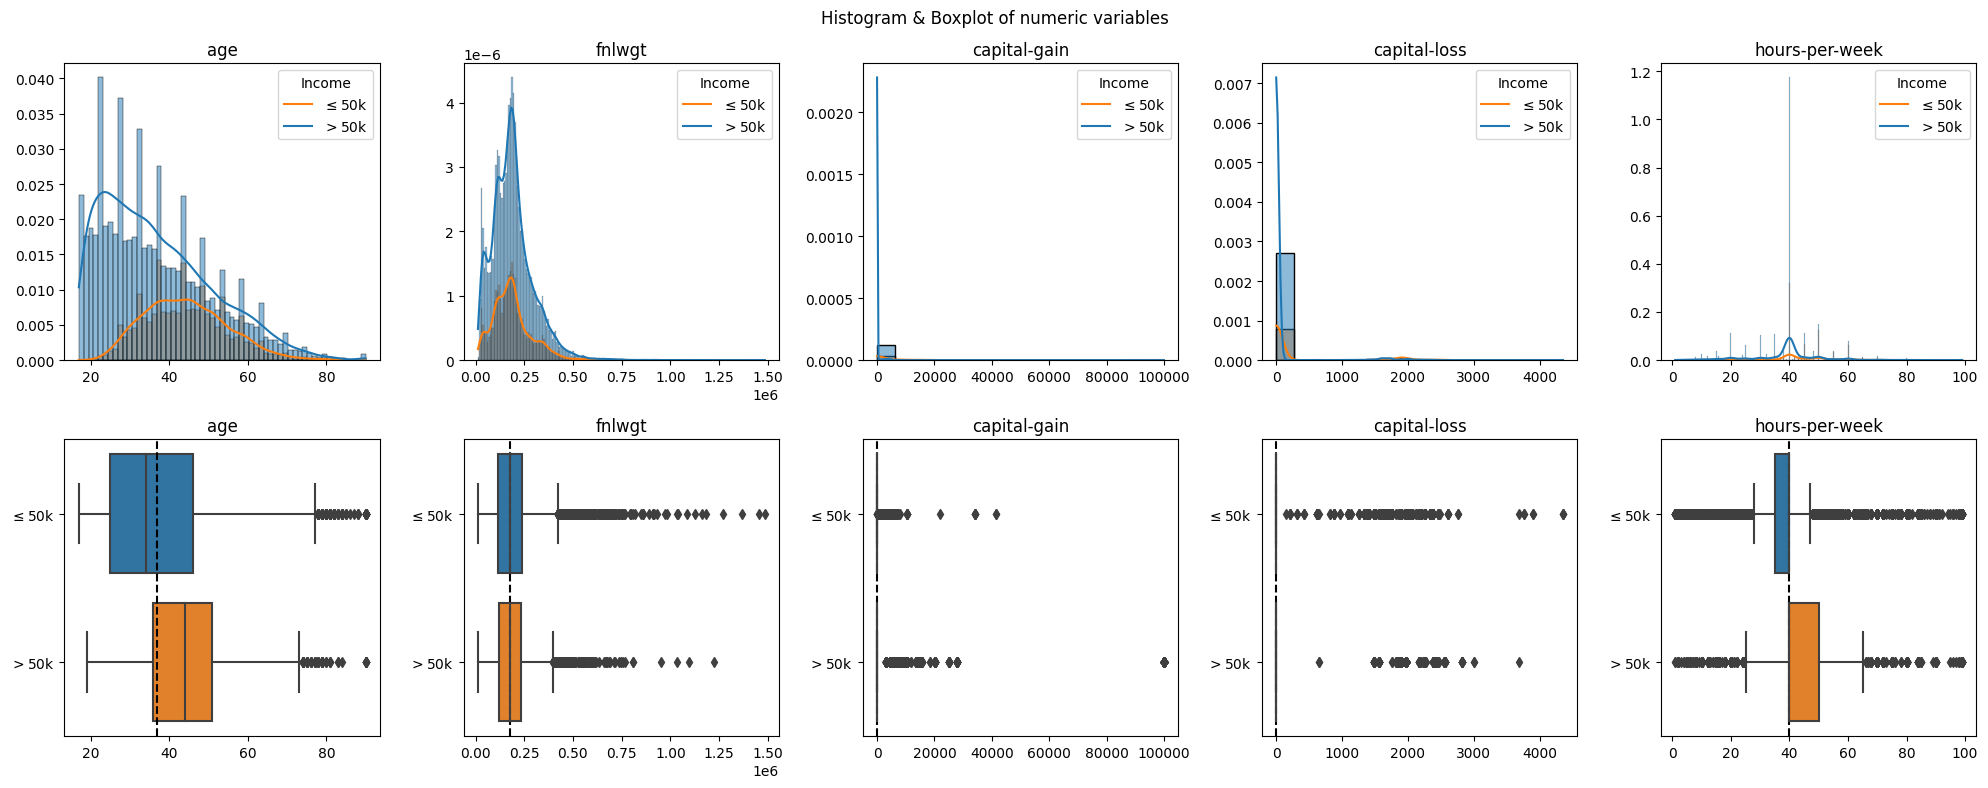

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=len(numeric), figsize=(20, 8))
fig.suptitle("Histogram & Boxplot of numeric variables")

for i, variable in enumerate(numeric):
    sns.histplot(data=train_df, x=variable, hue='income', ax=axes[0][i], kde=True, stat='density')
    sns.boxplot(data=train_df, x=variable, y='income', ax=axes[1][i], orient='h')

    axes[0][i].set_xlabel(None)
    axes[0][i].set_ylabel(None)
    axes[0][i].set_title(variable)
    axes[0][i].legend(title='Income', labels=['$\leq50$k', '$>50$k'])

    axes[1][i].set_xlabel(None)
    axes[1][i].set_ylabel(None)
    axes[1][i].set_title(variable)
    axes[1][i].set_yticklabels(['$\leq50$k', '$>50$k'])

    median = train_df[variable].median()
    axes[1][i].axvline(median, linestyle='--', color='black')
    
plt.tight_layout()
plt.show()

## Results

- We can delete the variable **native-country**. 
- We can encode **sex** to a binary variable
- encode all categorical variables

In [17]:
train_df = train_df.drop('native-country',axis= 1)
test_df = test_df.drop("native-country", axis = 1)
categorical.remove('native-country')

In [18]:
print(f'Train Shape before encoding: {train_df.shape}')
print(f'Test Shape before encoding: {test_df.shape}')

onehot_encoder = ce.OneHotEncoder(cols=categorical)
train_df = onehot_encoder.fit_transform(train_df)
test_df = onehot_encoder.transform(test_df)

print(f'Train Shape after encoding: {train_df.shape}')
print(f'Test Shape after encoding: {test_df.shape}')

train_df.head()

Train Shape before encoding: (32561, 13)
Test Shape before encoding: (16281, 13)
Train Shape after encoding: (32561, 64)
Test Shape after encoding: (16281, 64)


,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,fnlwgt,...,race_2,race_3,race_4,race_5,sex_1,sex_2,capital-gain,capital-loss,hours-per-week,income
0,39,1,0,0,0,0,0,0,0,77516,...,0,0,0,0,1,0,2174,0,40,0
1,50,0,1,0,0,0,0,0,0,83311,...,0,0,0,0,1,0,0,0,13,0
2,38,0,0,1,0,0,0,0,0,215646,...,0,0,0,0,1,0,0,0,40,0
3,53,0,0,1,0,0,0,0,0,234721,...,1,0,0,0,1,0,0,0,40,0
4,28,0,0,1,0,0,0,0,0,338409,...,1,0,0,0,0,1,0,0,40,0


# Principal component analysis (PCA)

### Notizen
https://setosa.io/ev/principal-component-analysis/
- PCA führt zu einem guten Verständnis der Daten
- Zur Entscheidung wie viele Hauptkomponenten gewählt werden kann man sich der erklärten Varianz zu nutze machen. (Proportion of variance explained PVE)
- Sie kann auch als Hilfsmittel für das überwachte Lernen vorgeschalten werden
- Vor der PCA sollte man alle Variable skalieren damit Sie alle die Varianz 1 besitzen und somit besser zueinander in Relation stehen
1. Standardisieren / Skalieren
2. Kovarianzmatrix berechnen
3. Eigenwerte und Eigenvektoren berechnen
4. Egenwerte und -vektoren sortieren (diejenigen mit den höchsten Werten haben die höchste Signifikanz)
5. Transform the original matrix of data by multiplying it top n eigenvectors selected above.

Oder Sklearn PCA



In [19]:
# from sklearn.decomposition import _pca
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# x_train_scale = scaler.transform(test_df)
# x_train_scale

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# Cluster Analyse

# Final Data 

In [ ]:
X_train = train_df.drop(['income'], axis=1)
Y_train = train_df['income']

X_test = test_df.drop(['income'], axis=1)
Y_test = test_df['income']

# Logit-Modell

# Neuronal Networks